# Exercise 2b: Feature engineering

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import os
os.chdir('/Users/keisukekonno/Documents/NTNU/ML_in_Practice/assignment')

In [3]:
X_train = pd.read_csv("ex2_train.csv")
y_train = pd.read_csv("ex2_class_train.csv")
X_test = pd.read_csv("ex2_test.csv")
y_test = pd.read_csv("ex2_class_test.csv")

In [4]:
def evaluate_result(X_test, y_test, clf):
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]  # Probability of positive class
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')
    print(f'AUC-ROC: {auc_roc:.4f}')
    
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'AUC-ROC': auc_roc
    }

## Prototyping (without feature engineering)

In [5]:
def preprocess(data_in):
    df = data_in.copy()
    data = df.drop(columns=['Name'])
    
    data['Age'].fillna(data['Age'].median(), inplace=True)
    data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)
    data['Fare'].fillna(data['Fare'].median(), inplace=True)

    # Convert categorical variables to dummy/indicator variables
    data = pd.get_dummies(data, columns=['Sex', 'Embarked'], drop_first=True)

    return data

In [6]:
X_train_processed_tmp = preprocess(X_train)
X_test_processed_tmp = preprocess(X_test)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_processed_tmp, y_train.values.ravel())
y_pred = clf.predict(X_test_processed_tmp)

print('Random Forest Model without Feature Engineering')
original_scores = evaluate_result(X_test_processed_tmp, y_test, clf)

# store the scores in a dictionary
scores = {}
scores['Original'] = original_scores

Random Forest Model without Feature Engineering
Accuracy: 0.8101
Precision: 0.7778
Recall: 0.7568
F1-score: 0.7671
AUC-ROC: 0.8736


## Let's visualize correlation before feature engineering

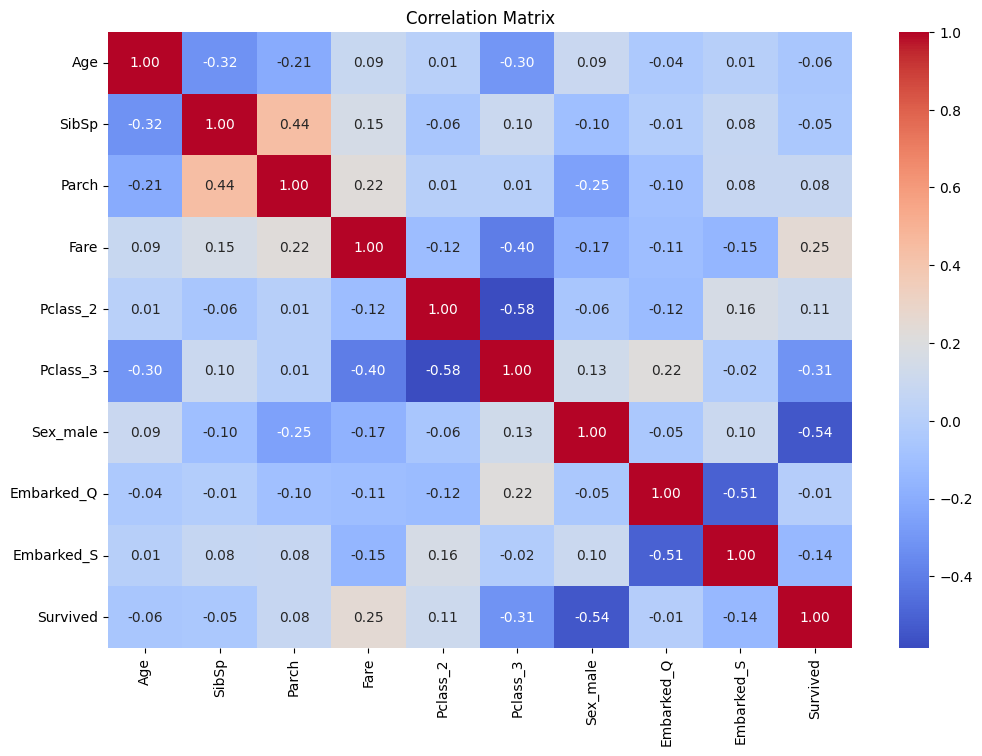

In [7]:
# One-hot encoding on Pclass, Sex, Embarked
corr_df = pd.get_dummies(X_train, columns=['Pclass', 'Sex', 'Embarked'], drop_first=True)

# Add y_train to the correlation matrix
corr_df = corr_df.drop(columns=['Name'])
corr_df['Survived'] = y_train
corr_df = corr_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_df, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Feature engineering

The classification using simple preprocessed data gives only mediocre performance.

**TODO: You should make use of the insights from your EDA (ex2a) to complete the following feature engineering function below.** Later the function will replace the simple preprocessing.

You will pass the exercise if your feature engineering can improve the performance (i.e., winning in three or more metrics).

## Grouping Titles

In [8]:
def process_titles(df):
    # Extract titles from names
    df['Title'] = df['Name'].apply(lambda x: re.search(' ([A-Z][a-z]+)\.', x).group(1))
    
    # Group titles into smaller categories
    df['NewTitle'] = df['Title'].map({
        'Master': 'Master',
        'Mlle': 'Miss',
        'Ms': 'Miss',
        'Miss': 'Miss'
    }).fillna('Other')
    
    # Assign 'Mr' to adult males
    df.loc[(df['Sex'] == 'male') & (df['NewTitle'] != 'Master'), 'NewTitle'] = 'Mr'
    
    # Assign 'Mrs' to adult females not already categorized as 'Miss'
    df.loc[(df['Sex'] == 'female') & (df['NewTitle'] == 'Other'), 'NewTitle'] = 'Mrs'
    
    return df

# Apply the function to X_train_processed
X_train_processed = process_titles(X_train)
X_test_processed = process_titles(X_test)

print(X_train_processed[['Name', 'Title', 'NewTitle']].head())
print(X_train_processed['NewTitle'].unique())

                                 Name Title NewTitle
0                 Partner, Mr. Austen    Mr       Mr
1          Berriman, Mr. William John    Mr       Mr
2                  Tikkanen, Mr. Juho    Mr       Mr
3             Hansen, Mr. Henrik Juul    Mr       Mr
4  Andersson, Miss. Ebba Iris Alfrida  Miss     Miss
['Mr' 'Miss' 'Mrs' 'Master']


## Family Size

In [9]:
def family_size(df):
    df['FamilySize'] = df['Parch'] + df['SibSp'] + 1
    return df

# Apply the function to X_train_processed
X_train_processed = family_size(X_train_processed)
X_test_processed = family_size(X_test_processed)

print(X_train_processed[['Parch', 'SibSp', 'FamilySize']].head())

   Parch  SibSp  FamilySize
0      0      0           1
1      0      0           1
2      0      0           1
3      0      1           2
4      2      4           7


## Null values in Age and Embarked

In [10]:
from sklearn.impute import SimpleImputer


def fill_null_values(df):
    # Use SimpleImputer to fill missing values
    imputer = SimpleImputer(strategy='most_frequent')
    # Reshape the data to 2D array
    embarked_2d = df['Embarked'].values.reshape(-1, 1)
    # Fit and transform the data
    df['Embarked'] = imputer.fit_transform(embarked_2d).ravel()

    # Use SimpleImputer to fill missing values
    imputer = SimpleImputer(strategy='mean')
    # Reshape the data to 2D array
    age_2d = df['Age'].values.reshape(-1, 1)
    # Fit and transform the data
    df['Age'] = imputer.fit_transform(age_2d).ravel()
    
    return df

# Apply the function to X_train_processed and X_test_processed
X_train_processed = fill_null_values(X_train_processed)
X_test_processed = fill_null_values(X_test_processed)

# Check the result
print(X_train_processed['Embarked'].isnull().sum())
print(X_test_processed['Embarked'].isnull().sum())
print(X_train_processed['Age'].isnull().sum())
print(X_test_processed['Age'].isnull().sum())

0
0
0
0


## One-hot encoding on NewTitle, Embarked, Sex, Pclass

In [11]:
def one_hot_encoding(df):
    df = pd.get_dummies(df, columns=['NewTitle', 'Embarked', 'Sex', 'Pclass'], drop_first=True)
    return df

# Apply the function to X_train_processed and X_test_processed
X_train_processed = one_hot_encoding(X_train_processed)
X_test_processed = one_hot_encoding(X_test_processed)

## Drop the unnecessary columns

In [12]:
def drop_unnecessary_columns(df):
    df = df.drop(columns=['Name', 'Title', 'SibSp', 'Parch'])
    return df

# Apply the function to X_train_processed and X_test_processed
X_train_processed = drop_unnecessary_columns(X_train_processed)
X_test_processed = drop_unnecessary_columns(X_test_processed)

## Check the transformed data

In [13]:
print(X_train_processed.info())
print(X_test_processed.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Age            712 non-null    float64
 1   Fare           712 non-null    float64
 2   FamilySize     712 non-null    int64  
 3   NewTitle_Miss  712 non-null    bool   
 4   NewTitle_Mr    712 non-null    bool   
 5   NewTitle_Mrs   712 non-null    bool   
 6   Embarked_Q     712 non-null    bool   
 7   Embarked_S     712 non-null    bool   
 8   Sex_male       712 non-null    bool   
 9   Pclass_2       712 non-null    bool   
 10  Pclass_3       712 non-null    bool   
dtypes: bool(8), float64(2), int64(1)
memory usage: 22.4 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Age            179 non-null    float64
 1   Fare           1

## Check correlation after feature engineering

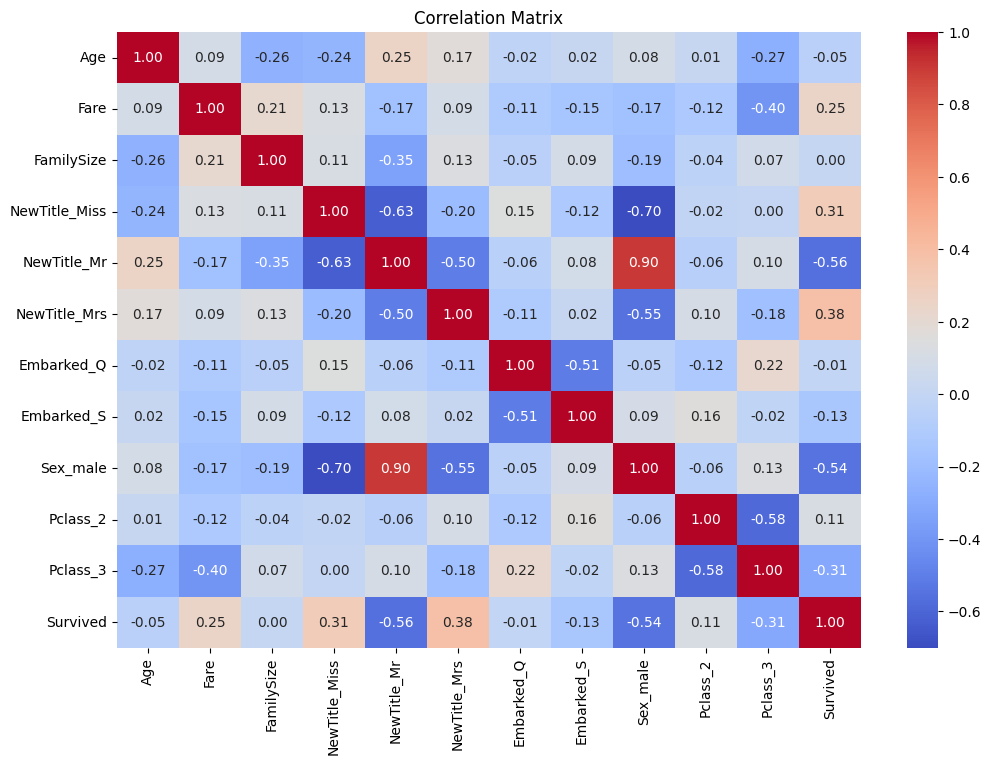

In [14]:
# add y_train to X_train_processed
corr_df = X_train_processed.copy()
corr_df['Survived'] = y_train

# Calculate the correlation matrix
corr_matrix = corr_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Grid Search

Grid Search Best parameters: {'max_depth': 5, 'n_estimators': 200}
Grid Search Best validation score: 0.769944864605306
Grid Search Best training score: 0.8567415730337079

               precision    recall  f1-score   support

           0       0.84      0.94      0.89       444
           1       0.88      0.71      0.79       268

    accuracy                           0.86       712
   macro avg       0.86      0.83      0.84       712
weighted avg       0.86      0.86      0.85       712



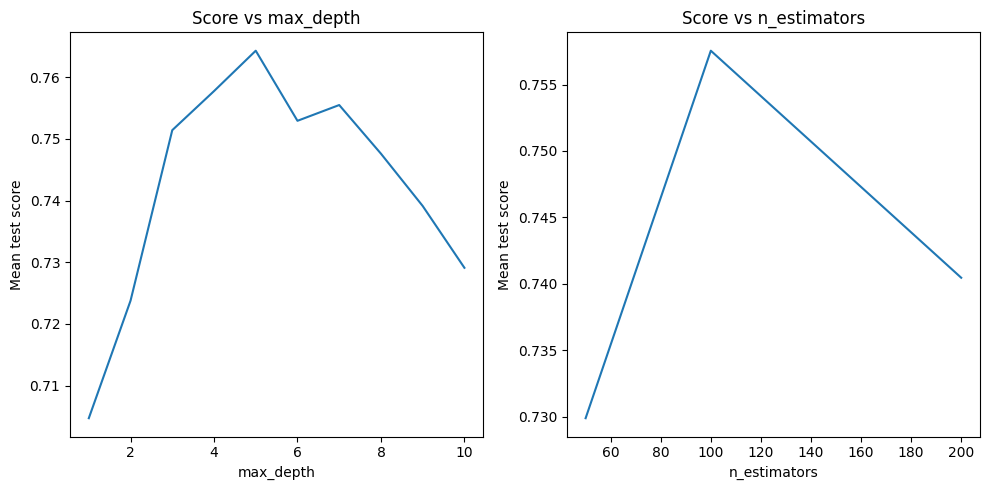

CPU times: user 8.57 s, sys: 81.8 ms, total: 8.65 s
Wall time: 8.37 s


In [15]:
%%time

import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

def fit_and_visualize(classifier, parameters, X, y):
    gscv = GridSearchCV(classifier, parameters, cv=5, scoring='f1')
    gscv.fit(X, y)

    print('Grid Search Best parameters:', gscv.best_params_)
    print('Grid Search Best validation score:', gscv.best_score_)
    print('Grid Search Best training score:', gscv.best_estimator_.score(X, y))

    X_pred = gscv.best_estimator_.predict(X)
    print('\n', classification_report(y, X_pred))

    # Visualize results
    results = gscv.cv_results_
    params = gscv.param_grid

    # Create a figure with subplots for each parameter
    fig, axes = plt.subplots(1, len(params), figsize=(5*len(params), 5))
    if len(params) == 1:
        axes = [axes]

    for idx, (param_name, param_range) in enumerate(params.items()):
        scores = results['mean_test_score']
        ax = axes[idx]
        ax.plot(param_range, scores.reshape(len(param_range), -1).mean(axis=1))
        ax.set_xlabel(param_name)
        ax.set_ylabel('Mean test score')
        ax.set_title(f'Score vs {param_name}')

    plt.tight_layout()
    plt.show()

    return gscv.best_estimator_

# Example usage:
param_dist = {
        'n_estimators': randint(50, 500),
        'max_depth': randint(1, 20),
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10),
        'max_features': uniform(0, 1),
        'bootstrap': [True, False]
    }
rf_gscv = fit_and_visualize(RandomForestClassifier(random_state=42), parameters, 
                            X_train_processed, y_train.values.ravel())

## Model Performance

In [16]:

print('Random Forest Model with Feature Engineering')
scores['Feature Engineering'] = evaluate_result(X_test_processed, y_test, rf_gscv)

Random Forest Model with Feature Engineering
Accuracy: 0.8268
Precision: 0.8209
Recall: 0.7432
F1-score: 0.7801
AUC-ROC: 0.8884


In [17]:
# Show how much scores have improved
print('Improvement in scores after feature engineering:')
for metric in scores['Feature Engineering']:
    print(f'{metric}: {scores["Feature Engineering"][metric] - scores["Original"][metric]:.4f}')

Improvement in scores after feature engineering:
Accuracy: 0.0168
Precision: 0.0431
Recall: -0.0135
F1-score: 0.0130
AUC-ROC: 0.0148
